In [93]:
%matplotlib inline

import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections

In [148]:
# From previous exercise
def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def psi(y):
    return 1 - 2 * sigmoid(y)

def update_natural(W, x):
    phee = psi(W.dot(x)).reshape(2,1)
    delta_W = np.dot(phee.dot(np.dot(W, x).reshape(1,2)), W)
    delta_W = delta_W + W # multiplied out delta function
    delta_W[0,0] = 0 # Bell-Seijnowski solution
    delta_W[1,1] = 0 # Bell-Seijnowski solution
    return delta_W

def plot(ax, data, **kwargs):
    ax.plot(data, **kwargs)
    if 'label' in kwargs:
        ax.set_title(kwargs['label'])
    # scipy.io.wavfile.write(kwargs['label'] + '.wav', 8192, data),

seed = 13
sound1 = np.loadtxt('sounds/sound1.dat')
sound2 = np.loadtxt('sounds/sound2.dat')
sounds = np.concatenate([[sound1, sound2]], axis=1)
A = np.linalg.inv(np.random.RandomState(seed+4).rand(2,2))
X0 = A.dot(sounds)
X = X0[:,np.random.RandomState(seed+1).permutation(X.shape[1])]
X -= X.mean(axis=1).reshape((2, 1))

Calculate unmixing matrix in 26 steps


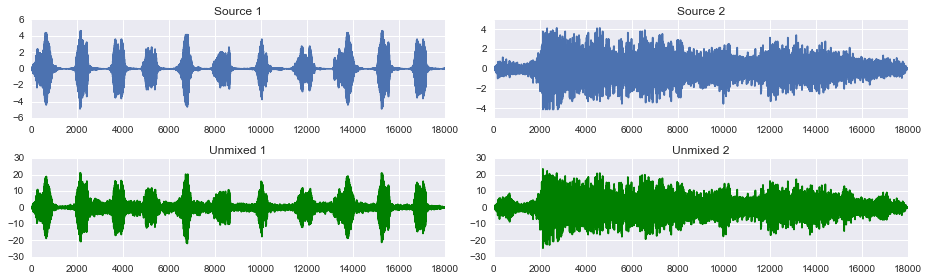

In [151]:
# 7.1. (a) Online ICA with natural gradient decaying slowly to 0
W = np.linalg.inv(np.random.RandomState(seed+1).rand(2,2))
W[0,0] = 1 # Bell-Seijnowski solution
W[1,1] = 1
lambda_ = 0.9  # 0.9999
epsilon = 0.01  # 0.00001
time = 0
eta = .15
while eta > epsilon:
    eta = eta * lambda_
    W += eta * update_natural(W, example)
    time += 1
unmixed_nat = W.dot(A.dot(sounds))

print("Calculated unmixing matrix in {} steps".format(time))
fig, ax = plt.subplots(2, 2, figsize=(13, 4))
plot(ax[0, 0], sound1, label='Source 1')
plot(ax[0, 1], sound2, label='Source 2')
plot(ax[1, 0], unmixed_nat[0,:], label='Unmixed 1', color='green')
plot(ax[1, 1], unmixed_nat[1,:], label='Unmixed 2', color='green')
fig.tight_layout()


In [96]:
mat = scipy.io.loadmat('distrib.mat')
uniform = mat['uniform']
normal = mat['normal']
laplacian = mat['laplacian']

A = np.array([[4,3],[2,1]])

In [97]:
def plot_dataset(data, title='', xlabel='Source 1', ylabel='Source 2'):
    df = pd.DataFrame(data.T, columns=[xlabel, ylabel])
#     g = sns.jointplot(x=xlabel, y=ylabel, data=df)
#     sns.plt.suptitle(title, fontsize=20, y=1.08)

In [98]:
def procedure(s):
    #Plot the original sources
    plot_dataset(s, title='Original sources')
    
    #7.3a - Apply mixing matrix A and plot mixed data
    x = np.dot(A,s)
    plot_dataset(x, title='After mixing', xlabel='Mixed 1', ylabel='Mixed 2')
    
    #7.3b - Center to mean 0 and plot centered data
    x = x - np.mean(x,axis=1).reshape(2,1)
    plot_dataset(x, title='After centering', xlabel='Centered 1', ylabel='Centered 2')
    
    #7.3c - Decorrelate by PCA and project onto the principal components
    # (consult: 1. eig vs eigh 2. should we sort eigvals?)
    covmat = np.cov(x)
    eigvals, eigvecs = np.linalg.eig(covmat)

In [99]:
procedure(normal)

In [100]:
def kurtosis_of_dist(s):
    x = np.dot(A,s)
    x -= np.mean(x)

In [101]:

# sns.set(color_codes=True)


# mean, cov = [0, 1], [(1, .5), (.5, 1)]
# data = np.random.multivariate_normal(mean, cov, 200)
# df = pd.DataFrame(data, columns=["x", "y"])

# sns.jointplot(x="x", y="y", data=df);